In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import theano as th
import theano.tensor as T
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import time

In [2]:
# Read the data and create DataFrame from it
data = pd.read_csv('16.csv', sep=';').replace(['DZN', 'Makula', 'SoftExudates', 'Vessels'], [0, 1, 2, 3])

In [3]:
# Check a few rows of the table
data.head()

,Unnamed: 0,name,area,class,gray_Mean,gray_Variance,gray_Skewness,gray_Kurtosis,gray_Perc.01%,gray_Perc.10%,...,"b_S(5,-5)SumVarnc","b_S(5,-5)SumEntrp","b_S(5,-5)Entropy","b_S(5,-5)DifVarnc","b_S(5,-5)DifEntrp",b_GrMean,b_GrVariance,b_GrSkewness,b_GrKurtosis,b_GrNonZeros
0,504914,25-May-2012 12-44-02,100,0,"162,87","25,6731","0,0556933442808038","-0,847312470433456","153,0","156,0",...,"19020,2920239063","1,0185245113550199","1,59059920589699","37,6861925522195","1,00034500883477","4,04366697163015","4,68000742254742","0,469840716855728","-0,739006133152813","1,0"
1,504915,25-May-2012 12-44-02,100,0,"163,22","34,0916","-0,184628743255271","-1,17512428138866","152,0","155,0",...,"18872,185673506498","1,12394386122761","1,62672280537666","27,945501012950896","0,861753508048933","4,51488268129824","4,38145937411324","0,139565167526377","-0,8441575745042179","1,0"
2,504916,25-May-2012 12-44-02,100,0,"166,02","36,3396","-0,213090557717068","-1,34859723534067","155,0","158,0",...,"18936,2296403973","0,9450748123142929","1,50017250441739","34,9389659370051","0,9521802095285329","3,42635982214587","2,77568336918453","0,258781983309002","-0,45019100421053404","0,96875"
3,504917,25-May-2012 12-44-02,100,0,"163,57","32,7051","-0,23953206151099998","-0,7412659193903579","151,0","155,0",...,"19341,6490470399","1,0185245113550199","1,5694682548103003","21,2180474577127","0,793004206059718","3,5684615219362903","3,68795736646017","0,44332061765059905","0,0231065255473104","0,953125"
4,504918,25-May-2012 12-44-02,100,0,"162,73","35,4571","-0,0356651425692793","-1,45781568758918","153,0","155,0",...,"18475,989997983","0,9944421117018969","1,63876400520322","45,426724314094706","0,9944421117018969","4,28622945998813","4,92511201632983","-0,0128182902511431","-1,1049856517508898","1,0"


In [4]:
y = data['class']
print(y.value_counts())

0    6004
1    3517
2    2454
3    1079
Name: class, dtype: int64


In [5]:
y = data.pop('class')
#даже если переводить всё это дело в таймстамп, получается так себе
data.pop('name')
x = data

In [6]:
#форматируем всю х***ю
#datePattern = '%d-%B-%Y %H-%M-%S'
cols = x.columns
#for index, row in x.head().iterrows():
for index, row in x.iterrows():
    #мутирущий код зло, но мне лень -_-
    #if (isinstance(x.at[index, 'name'], str)):
    #    trueDate = datetime.strptime(x.at[index, 'name'], datePattern)
    #    x.at[index, 'name'] = datetime.timestamp(trueDate)
    
    for col in cols:
        if (isinstance(x.at[index, col], str)):
            x.at[index, col] = x.at[index, col].replace(',', '.', 1)

In [7]:
#меням тип
for col in cols:
    x[col] = pd.to_numeric(x[col])

In [8]:
#сдвигаем отрицательные
for col in cols:
    minColVal = x[col].min()
    if (minColVal < 0):
        for index, row in x.iterrows():
            x.at[index, col] -= minColVal

In [9]:
x.dtypes

Unnamed: 0               int64
area                     int64
gray_Mean              float64
gray_Variance          float64
gray_Skewness          float64
gray_Kurtosis          float64
gray_Perc.01%          float64
gray_Perc.10%          float64
gray_Perc.50%          float64
gray_Perc.90%          float64
gray_Perc.99%          float64
gray_S(1,0)AngScMom    float64
gray_S(1,0)Contrast    float64
gray_S(1,0)Correlat    float64
gray_S(1,0)SumOfSqs    float64
gray_S(1,0)InvDfMom    float64
gray_S(1,0)SumAverg    float64
gray_S(1,0)SumVarnc    float64
gray_S(1,0)SumEntrp    float64
gray_S(1,0)Entropy     float64
gray_S(1,0)DifVarnc    float64
gray_S(1,0)DifEntrp    float64
gray_S(0,1)AngScMom    float64
gray_S(0,1)Contrast    float64
gray_S(0,1)Correlat    float64
gray_S(0,1)SumOfSqs    float64
gray_S(0,1)InvDfMom    float64
gray_S(0,1)SumAverg    float64
gray_S(0,1)SumVarnc    float64
gray_S(0,1)SumEntrp    float64
                        ...   
b_S(0,5)Entropy        float64
b_S(0,5)

In [10]:
N = 4
K = 17

In [11]:
stand_X = preprocessing.scale(x)
norm_X = preprocessing.MinMaxScaler().fit_transform(stand_X)
print(norm_X)

/home/akakyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


[[0.00000000e+00 0.00000000e+00 6.72184017e-01 ... 4.42243172e-01
  6.29448677e-02 1.00000000e+00]
 [7.66107408e-05 0.00000000e+00 6.73843965e-01 ... 3.44791273e-01
  5.49957911e-02 1.00000000e+00]
 [1.53221482e-04 0.00000000e+00 6.87123548e-01 ... 3.79967674e-01
  8.47782687e-02 9.09090909e-01]
 ...
 [9.99846779e-01 1.00000000e+00 2.83886649e-01 ... 4.89072869e-01
  1.43858074e-01 9.37149270e-01]
 [9.99923389e-01 1.00000000e+00 2.52157932e-01 ... 4.62395601e-01
  1.43714671e-01 8.92255892e-01]
 [1.00000000e+00 1.00000000e+00 2.66492767e-01 ... 4.95572304e-01
  1.42125996e-01 8.83277217e-01]]


In [12]:
best_features = SelectKBest(score_func=chi2, k= N + K)
fit_k = best_features.fit(norm_X, y)

In [13]:
accuracy_Kbest = []
model_norm = SGDClassifier(loss='log', penalty='l1', l1_ratio=1.)
best_features = pd.DataFrame(data=fit_k.scores_, index=x.columns, columns=['chi2_score'])
accuracy_trees = []
model_tree = ExtraTreesClassifier().fit(norm_X, y)
importance_features = pd.DataFrame(data=model_tree.feature_importances_, index=x.columns, columns=['feature_importance'])

/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [14]:
for i in range(N, N + K):
    print(i, 'features: ')
    best = best_features.nlargest(i, 'chi2_score').index
    print('\t Kbest:', best)
    kbest_x = x[best]
    kbest_cvs = cross_val_score(model_norm, (kbest_x - kbest_x.mean(axis=0))/kbest_x.std(axis=0), y, cv = 5)
    accuracy_Kbest.append(np.mean(kbest_cvs))
    importance = importance_features.nlargest(i, 'feature_importance').index
    print('\t Trees:', importance)
    tree_x = x[importance]
    trees_cvs = cross_val_score(model_norm, (tree_x - tree_x.mean(axis=0))/tree_x.std(axis=0), y, cv = 5)
    accuracy_trees.append(np.mean(trees_cvs))
print(' \n Accuracy Kbest: ' ,accuracy_Kbest)
print(' \n Accuracy trees: ' ,accuracy_trees)

4 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

5 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

6 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

7 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

8 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

9 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

10 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

11 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc', 'r_S(3,0)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg', 'r_S(5,-5)SumAverg'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

12 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc', 'r_S(3,0)SumVarnc', 'r_S(1,1)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg', 'r_S(5,-5)SumAverg', 'gray_S(0,1)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

13 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc', 'r_S(3,0)SumVarnc', 'r_S(1,1)SumVarnc',
       'r_S(5,-5)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg', 'r_S(5,-5)SumAverg', 'gray_S(0,1)SumVarnc',
       'b_S(3,3)DifEntrp'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

14 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc', 'r_S(3,0)SumVarnc', 'r_S(1,1)SumVarnc',
       'r_S(5,-5)SumVarnc', 'r_S(4,0)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg', 'r_S(5,-5)SumAverg', 'gray_S(0,1)SumVarnc',
       'b_S(3,3)DifEntrp', 'r_S(0,4)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

15 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc', 'r_S(3,0)SumVarnc', 'r_S(1,1)SumVarnc',
       'r_S(5,-5)SumVarnc', 'r_S(4,0)SumVarnc', 'r_S(5,0)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg', 'r_S(5,-5)SumAverg', 'gray_S(0,1)SumVarnc',
       'b_S(3,3)DifEntrp', 'r_S(0,4)SumVarnc', 'r_S(4,-4)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

16 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc', 'r_S(3,0)SumVarnc', 'r_S(1,1)SumVarnc',
       'r_S(5,-5)SumVarnc', 'r_S(4,0)SumVarnc', 'r_S(5,0)SumVarnc',
       'r_S(2,0)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg', 'r_S(5,-5)SumAverg', 'gray_S(0,1)SumVarnc',
       'b_S(3,3)DifEntrp', 'r_S(0,4)SumVarnc', 'r_S(4,-4)SumVarnc',
       'g_S(2,2)SumAverg'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

17 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc', 'r_S(3,0)SumVarnc', 'r_S(1,1)SumVarnc',
       'r_S(5,-5)SumVarnc', 'r_S(4,0)SumVarnc', 'r_S(5,0)SumVarnc',
       'r_S(2,0)SumVarnc', 'r_S(0,1)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg', 'r_S(5,-5)SumAverg', 'gray_S(0,1)SumVarnc',
       'b_S(3,3)DifEntrp', 'r_S(0,4)SumVarnc', 'r_S(4,-4)SumVarnc',
       'g_S(2,2)SumAverg', 'gray_S(1,0)SumAverg'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

18 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc', 'r_S(3,0)SumVarnc', 'r_S(1,1)SumVarnc',
       'r_S(5,-5)SumVarnc', 'r_S(4,0)SumVarnc', 'r_S(5,0)SumVarnc',
       'r_S(2,0)SumVarnc', 'r_S(0,1)SumVarnc', 'r_S(0,5)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg', 'r_S(5,-5)SumAverg', 'gray_S(0,1)SumVarnc',
       'b_S(3,3)DifEntrp', 'r_S(0,4)SumVarnc', 'r_S(4,-4)SumVarnc',
       'g_S(2,2)SumAverg', 'gray_S(1,0)SumAverg', 'gray_Mean'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

19 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc', 'r_S(3,0)SumVarnc', 'r_S(1,1)SumVarnc',
       'r_S(5,-5)SumVarnc', 'r_S(4,0)SumVarnc', 'r_S(5,0)SumVarnc',
       'r_S(2,0)SumVarnc', 'r_S(0,1)SumVarnc', 'r_S(0,5)SumVarnc',
       'r_S(1,0)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg', 'r_S(5,-5)SumAverg', 'gray_S(0,1)SumVarnc',
       'b_S(3,3)DifEntrp', 'r_S(0,4)SumVarnc', 'r_S(4,-4)SumVarnc',
       'g_S(2,2)SumAverg', 'gray_S(1,0)SumAverg', 'gray_Mean',
       'r_S(5,0)DifEntrp'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

20 features: 
	 Kbest: Index(['r_S(3,-3)SumVarnc', 'r_S(3,3)SumVarnc', 'r_S(2,2)SumVarnc',
       'r_S(2,-2)SumVarnc', 'r_S(4,-4)SumVarnc', 'r_S(0,3)SumVarnc',
       'r_S(4,4)SumVarnc', 'r_S(1,-1)SumVarnc', 'r_S(0,2)SumVarnc',
       'r_S(0,4)SumVarnc', 'r_S(3,0)SumVarnc', 'r_S(1,1)SumVarnc',
       'r_S(5,-5)SumVarnc', 'r_S(4,0)SumVarnc', 'r_S(5,0)SumVarnc',
       'r_S(2,0)SumVarnc', 'r_S(0,1)SumVarnc', 'r_S(0,5)SumVarnc',
       'r_S(1,0)SumVarnc', 'r_S(5,5)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

	 Trees: Index(['r_S(1,0)SumAverg', 'r_S(4,4)SumVarnc', 'b_S(0,1)SumAverg',
       'r_S(0,3)SumVarnc', 'g_S(4,4)SumAverg', 'g_S(1,1)SumAverg',
       'g_S(1,-1)SumAverg', 'gray_S(3,3)SumAverg', 'r_Perc.50%',
       'r_S(0,1)SumAverg', 'r_S(5,-5)SumAverg', 'gray_S(0,1)SumVarnc',
       'b_S(3,3)DifEntrp', 'r_S(0,4)SumVarnc', 'r_S(4,-4)SumVarnc',
       'g_S(2,2)SumAverg', 'gray_S(1,0)SumAverg', 'gray_Mean',
       'r_S(5,0)DifEntrp', 'r_S(0,1)SumVarnc'],
      dtype='object')


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, t

 
 Accuracy Kbest:  [0.7787670465375598, 0.7883285053282056, 0.8068833529092382, 0.7949243268546488, 0.8005892794843511, 0.7790088531872412, 0.8167717518378798, 0.792395856436026, 0.8007515494217421, 0.8013629327372996, 0.803131846259993, 0.8112531052474843, 0.809711171571007, 0.7828239159187917, 0.798449617073166, 0.8238855675275089, 0.7966919495021574]
 
 Accuracy trees:  [0.9299136531519814, 0.9505173808850275, 0.9499823621021729, 0.9497514793600537, 0.9492927655137479, 0.9535055945217149, 0.9489079499988465, 0.9523571666488271, 0.9524334138783075, 0.9571828468818477, 0.9576404149977149, 0.9586376119850415, 0.9587145041123757, 0.9580247019734422, 0.9561086104634857, 0.9596326357592562, 0.9564933085402298]


/home/akakyi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


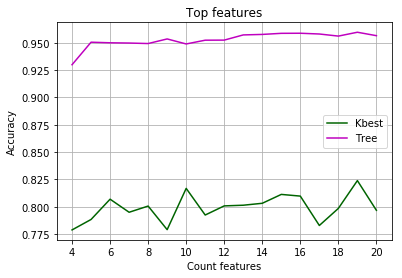

In [15]:
count = range(N, N+K)
plt.plot(count, accuracy_Kbest, color='darkgreen', label='Kbest')
plt.plot(count, accuracy_trees, color='m', label='Tree')
plt.xlabel('Count features')
plt.ylabel('Accuracy')
plt.title('Top features')
plt.legend()
plt.grid()
plt.show()

In [16]:
best_features = preprocessing.scale(preprocessing.MinMaxScaler().fit_transform(x[['b_S(4,0)SumVarnc', 'b_Perc.01%', 'b_S(4,-4)SumVarnc',
       'gray_S(0,3)SumAverg', 'b_S(0,2)SumAverg', 'gray_S(0,3)SumVarnc',
       'g_Perc.99%', 'r_S(4,4)SumVarnc', 'g_S(2,-2)SumVarnc', 'gray_Perc.01%',
       'b_Perc.90%', 'b_S(3,-3)SumVarnc', 'b_S(2,0)SumAverg',
       'gray_S(5,0)SumVarnc', 'b_S(5,5)SumAverg']]))

In [17]:
learning_rate=0.01

def init_weights(D, H):
    W = np.random.randn(D, H) / np.sqrt(D)
    b = np.zeros(H)
    
    W = th.shared(W)
    b = th.shared(b)
    return W, b
    

def create_layer(x, W, b, activation=T.tanh):
    x = T.dot(x, W) + b
    if activation is not None:
        x = activation(x)
    return x

In [18]:
def train(X, Y, count_neurons, epochs):
    print('test')
    x = T.vector('x')

    W1, b1 = init_weights(D=15, H=count_neurons)
    out_l1 = create_layer(x, W1, b1)

    W2, b2 = init_weights(D=count_neurons, H=len(np.unique(Y)))
    out_l2 = create_layer(out_l1, W2, b2, activation=None)
    
    classification_out = T.nnet.softmax(out_l2)

    softmax_out = th.function(
        inputs=[x],
        outputs=classification_out
    )
    
    loss = -T.log(classification_out + 1e-13)
    
    label = T.scalar('y', dtype=T.int32) 

    class_loss = loss[0, label]

    loss_val = th.function(
        inputs=[x, label],
        outputs=class_loss
    )
    
    W1_grad = T.grad(class_loss, W1)
    b1_grad = T.grad(class_loss, b1)
    W2_grad = T.grad(class_loss, W2)
    b2_grad = T.grad(class_loss, b2)

    update_W1 = W1 - learning_rate * W1_grad
    update_b1 = b1 - learning_rate * b1_grad
    update_W2 = W2 - learning_rate * W2_grad
    update_b2 = b2 - learning_rate * b2_grad

    updates = [
        (W1, update_W1),
        (b1, update_b1),
        (W2, update_W2),
        (b2, update_b2)
    ]

    train_op = th.function(
        inputs=[x, label],
        outputs=class_loss,
        updates=updates
    )
    
    accuracy = []
    loss = []
    time_train = 0
    for i in range(epochs):
        for j in range(len(X)):
            label = Y[j]
            x_in = X[j]
            start = time.time()
            #print(x_in)
            #print(label)
            _ = train_op(x_in, label)
            end = time.time()
            time_train += (end - start)
        n_correct = 0
        loss_values = []
        for j in range(len(X)):
            label = Y[j]
            x_in = X[j]
            loss_values += [loss_val(x_in, label)]
            answer = softmax_out(x_in)

            n_correct += np.argmax(answer[0]) == label
        accuracy.append(n_correct / len(X))
        loss.append(sum(loss_values) / len(X))
        print('Accuracy:', accuracy[-1])
        print('Mean loss:', loss[-1])
        print(str(i+1)+'/'+str(epochs))
    
    return [accuracy, loss, time_train]

In [19]:
#zzz = {'DZN': 0, 'Makula': 1, 'SoftExudates': 2, 'Vessels': 3}
#for i in range(0, y.size):
#    y[i] = zzz[y[i]]
    
#print(y)

In [21]:
accuracy_all = []
loss_all = []
time_all = []
# hidden_layer = [i for i in range(10, 20)]
hidden_layer = [15, 50, 100, 200]

epochs = 30

for i in hidden_layer:
    print('Hidden neurons:', i)
    accuracy_i, loss_i, time_i = train(np.array(best_features), y, i, epochs)
    accuracy_all.append(accuracy_i)
    loss_all.append(loss_i)
    time_all.append(time_i)
    
print(accuracy_all)

Hidden neurons: 15
test


/home/akakyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  # This is added back by InteractiveShellApp.init_path()


Accuracy: 0.7459016393442623
Mean loss: 0.6989838038892336
1/30
Accuracy: 0.7571625555385323
Mean loss: 0.625462033556095
2/30
Accuracy: 0.7787651294622338
Mean loss: 0.5889986889746003
3/30
Accuracy: 0.7975333231193504
Mean loss: 0.5627961971807837
4/30
Accuracy: 0.8148460242071396
Mean loss: 0.5400688498295503
5/30
Accuracy: 0.8287115060517849
Mean loss: 0.516102109406982
6/30
Accuracy: 0.8356825494101425
Mean loss: 0.4938735407190659
7/30
Accuracy: 0.8412747050712426
Mean loss: 0.4728086323963402
8/30
Accuracy: 0.8459476022675042
Mean loss: 0.4524212850836021
9/30
Accuracy: 0.8503906848475563
Mean loss: 0.43029474482180446
10/30
Accuracy: 0.8562892599969358
Mean loss: 0.4092517933199203
11/30
Accuracy: 0.860119503600429
Mean loss: 0.3944035374416775
12/30
Accuracy: 0.8639497472039221
Mean loss: 0.38625044191798175
13/30
Accuracy: 0.8660946836218784
Mean loss: 0.3856614857461653
14/30
Accuracy: 0.8689290638884634
Mean loss: 0.3883255915585583
15/30
Accuracy: 0.8731423318523058
Mean l

/home/akakyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  # This is added back by InteractiveShellApp.init_path()


Accuracy: 0.746667688064961
Mean loss: 0.8034400680170665
1/30
Accuracy: 0.76405699402482
Mean loss: 0.7250181946900658
2/30
Accuracy: 0.7829017925540064
Mean loss: 0.6626442550769657
3/30
Accuracy: 0.7957714110617435
Mean loss: 0.6323997304555607
4/30
Accuracy: 0.8072621418722231
Mean loss: 0.6128216542761264
5/30
Accuracy: 0.8189060824268424
Mean loss: 0.5868905535516415
6/30
Accuracy: 0.8289413206679945
Mean loss: 0.551551890788601
7/30
Accuracy: 0.8357591542822124
Mean loss: 0.5133571116919102
8/30
Accuracy: 0.840508656350544
Mean loss: 0.47986101771692324
9/30
Accuracy: 0.8461008120116439
Mean loss: 0.4527896877064869
10/30
Accuracy: 0.8517695725448139
Mean loss: 0.4318561786814476
11/30
Accuracy: 0.8585874061590317
Mean loss: 0.4166926362335098
12/30
Accuracy: 0.862953883867014
Mean loss: 0.40593674270845476
13/30
Accuracy: 0.8667075225984373
Mean loss: 0.3984527501457571
14/30
Accuracy: 0.8704611613298606
Mean loss: 0.39343847837615664
15/30
Accuracy: 0.8745212195495633
Mean los

/home/akakyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  # This is added back by InteractiveShellApp.init_path()


Accuracy: 0.7695725448138502
Mean loss: 0.7685798055117273
1/30
Accuracy: 0.7920177723303202
Mean loss: 0.6560422948166471
2/30
Accuracy: 0.8064194882794545
Mean loss: 0.6060324301454203
3/30
Accuracy: 0.8165313313926765
Mean loss: 0.578582298490033
4/30
Accuracy: 0.826413359889689
Mean loss: 0.5516009668260011
5/30
Accuracy: 0.8326183545273479
Mean loss: 0.5192654518623475
6/30
Accuracy: 0.8382105101884479
Mean loss: 0.4862330268491847
7/30
Accuracy: 0.8428834073847097
Mean loss: 0.4576216620483501
8/30
Accuracy: 0.8492416117665084
Mean loss: 0.43479166200081887
9/30
Accuracy: 0.8548337674276084
Mean loss: 0.4167148073061674
10/30
Accuracy: 0.8619580205301057
Mean loss: 0.40211763224525
11/30
Accuracy: 0.8687758541443236
Mean loss: 0.39048882831028653
12/30
Accuracy: 0.8738317757009346
Mean loss: 0.38113472758666295
13/30
Accuracy: 0.878657882641336
Mean loss: 0.3732651784003319
14/30
Accuracy: 0.8824881262448292
Mean loss: 0.36641877321179
15/30
Accuracy: 0.8863949747203922
Mean loss

/home/akakyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  # This is added back by InteractiveShellApp.init_path()


Accuracy: 0.7925540064348092
Mean loss: 0.8108746604043497
1/30
Accuracy: 0.816301516776467
Mean loss: 0.6978823349268976
2/30
Accuracy: 0.829783974260763
Mean loss: 0.6338391270934169
3/30
Accuracy: 0.8358357591542822
Mean loss: 0.5829107261464945
4/30
Accuracy: 0.839895817373985
Mean loss: 0.5337288173355714
5/30
Accuracy: 0.8430366171288494
Mean loss: 0.48892111518550474
6/30
Accuracy: 0.8459476022675042
Mean loss: 0.45250424641396064
7/30
Accuracy: 0.8497012409989275
Mean loss: 0.4241532838679355
8/30
Accuracy: 0.8569020989734947
Mean loss: 0.40201532583641353
9/30
Accuracy: 0.864026352075992
Mean loss: 0.3845332337813825
10/30
Accuracy: 0.8709207905622798
Mean loss: 0.3705944425793218
11/30
Accuracy: 0.87635973647924
Mean loss: 0.35939924536936396
12/30
Accuracy: 0.8819518921403401
Mean loss: 0.3503426657173135
13/30
Accuracy: 0.8857055308717634
Mean loss: 0.3429689309722756
14/30
Accuracy: 0.8909912670445841
Mean loss: 0.3369444880242043
15/30
Accuracy: 0.8942086716715183
Mean lo

## Лучшей нейронной сетью оказалась сеть с 15-ю скрытыми нейронами и точностью 0.9274551861498391